In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import sklearn.datasets as skd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#Generating synthetic dataset 
X,y = skd.make_regression(n_samples=100, n_features=1, n_targets=1, bias=0.5, noise=5.5, random_state=42)

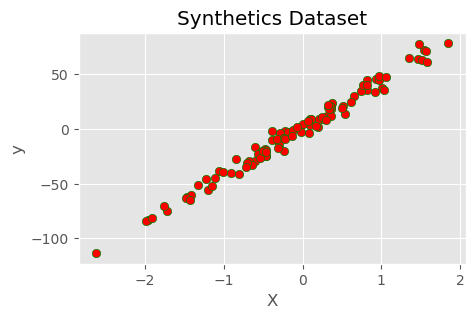

In [3]:
plt.figure(figsize = (5,3))
plt.style.use('ggplot')
plt.scatter(X[:,0], y, color='red', edgecolor='green')
#plt.scatter(X[:,1], y)
plt.title('Synthetics Dataset')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [4]:
#preparing the Tensor dataset
inputs = torch.tensor(X, dtype=torch.float32)
targets = torch.tensor(y, dtype = torch.float32)
dataset = TensorDataset(inputs, targets)

In [5]:
#train, test and validation set formation
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

dataset_size = int(len(dataset))
train_size = int(train_ratio * dataset_size)
test_size = int(test_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#finding the shape of the dataset
data, label = next(iter(train_dataset))

print(data.shape, label.shape)

torch.Size([1]) torch.Size([])


In [6]:
#Define the Neural Network for Regression
class Regression(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
#Creating the model, loss function and optimizer
model = Regression(input_size = 1, output_size=1, hidden_size = 64)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [8]:
#Batch processing the training, validation and testsets
train_loader = DataLoader(train_dataset, batch_size = 5, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 5)
test_loader = DataLoader(test_dataset, batch_size = 10)

In [9]:
#R^2 Calculation
from sklearn.metrics import r2_score

def calculate_r2(model, loader):
    targets = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            predictions.extend(output.view(-1).tolist())
            targets.extend(target.view(-1).tolist())
    
    return r2_score(targets, predictions)

In [10]:
#List to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

#Training and validation loop
n_epoch = 100
for epoch in range(n_epoch):
    model.train()
    train_loss = 0.0
    total = 0
    for data, label in train_loader:
        optimizer.zero_grad()
        output = model(data).view(-1) 
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
   
    #validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for data, target in val_loader:
            output = model(data)
            loss = criterion(data, output)
            val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
    
    #caluting r2 for training and validation set
    train_r2 = calculate_r2(model, train_loader)
    val_r2 = calculate_r2(model, val_loader)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)
    
    
    print(f'Epoch {epoch + 1}, Train_loss: {avg_train_loss}, Val_loss: {avg_val_loss}, Train_R^2:{ train_r2}, Val_R^2: {val_r2}')
    


Epoch 1, Train_loss: 1754.436208452497, Val_loss: 0.226035725325346, Train_R^2:-0.001011167976828986, Val_R^2: -0.07917903912656366
Epoch 2, Train_loss: 1714.9476514543805, Val_loss: 0.15093822591006756, Train_R^2:0.031152273470655856, Val_R^2: -0.03985402035722441
Epoch 3, Train_loss: 1635.5882808140345, Val_loss: 3.7334101796150208, Train_R^2:0.10334246293276161, Val_R^2: 0.0496684575833658
Epoch 4, Train_loss: 1457.9647718157087, Val_loss: 24.534952640533447, Train_R^2:0.23903681052658476, Val_R^2: 0.2083649998296857
Epoch 5, Train_loss: 1143.0588640485491, Val_loss: 125.07666015625, Train_R^2:0.4660877931184425, Val_R^2: 0.4783269824389217
Epoch 6, Train_loss: 701.4027083260672, Val_loss: 398.7713928222656, Train_R^2:0.7332532118692248, Val_R^2: 0.7618128241234237
Epoch 7, Train_loss: 303.99015801293507, Val_loss: 986.0722961425781, Train_R^2:0.9235527105326033, Val_R^2: 0.9286130680017327
Epoch 8, Train_loss: 81.36128561837333, Val_loss: 1360.8075256347656, Train_R^2:0.96917638966

Epoch 66, Train_loss: 20.643141201564244, Val_loss: 1259.2017974853516, Train_R^2:0.987080269645531, Val_R^2: 0.9745441051920103
Epoch 67, Train_loss: 21.198418191501073, Val_loss: 1336.5020141601562, Train_R^2:0.9876649740865545, Val_R^2: 0.9680362703621116
Epoch 68, Train_loss: 24.606944969722203, Val_loss: 1319.8439178466797, Train_R^2:0.9877038556815555, Val_R^2: 0.9692238646377493
Epoch 69, Train_loss: 21.685330271720886, Val_loss: 1224.068603515625, Train_R^2:0.9866811820611523, Val_R^2: 0.9744578452839829
Epoch 70, Train_loss: 21.678048508507864, Val_loss: 1323.4506225585938, Train_R^2:0.9860781207366348, Val_R^2: 0.9658158815444746
Epoch 71, Train_loss: 21.07728542600359, Val_loss: 1325.1346435546875, Train_R^2:0.9873998531997538, Val_R^2: 0.9729211940767257
Epoch 72, Train_loss: 21.36650255748204, Val_loss: 1254.5660858154297, Train_R^2:0.9884501179807912, Val_R^2: 0.9747304361809567
Epoch 73, Train_loss: 23.8998022377491, Val_loss: 1283.6330108642578, Train_R^2:0.987861723035

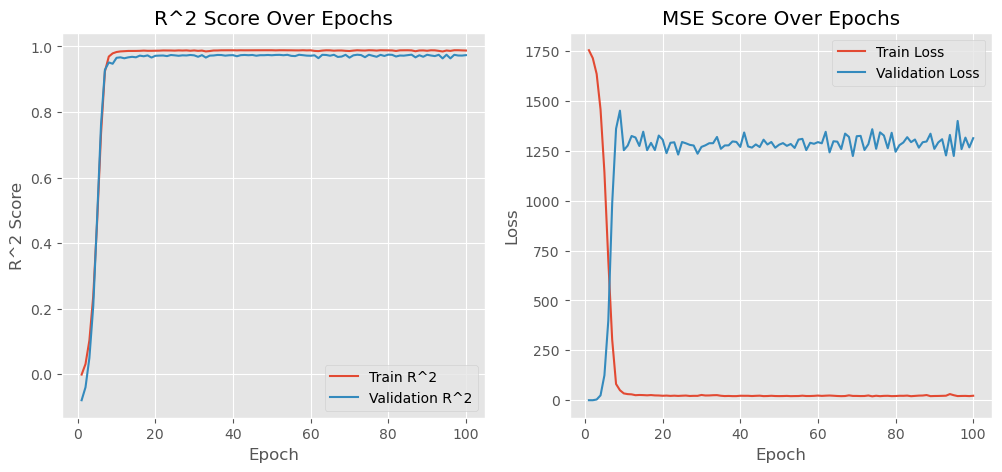

In [11]:
# Plotting MSE loss and the R^2 scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epoch+1), train_r2_scores, label='Train R^2')
plt.plot(range(1, n_epoch+1), val_r2_scores, label='Validation R^2')
plt.xlabel('Epoch')
plt.ylabel('R^2 Score')
plt.title('R^2 Score Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epoch+1), train_losses, label = 'Train Loss')
plt.plot(range(1, n_epoch+1), val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Score Over Epochs')
plt.legend()
plt.show()

In [12]:
#performance on the testset
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for data, target in test_loader:
        output = model(data)
        #output = output.view(-1)
        loss = criterion(output, data)
        test_loss += loss.item()
    avg_test_loss = test_loss/len(test_loader)
    test_r2_score = calculate_r2(model, test_loader)

print(f'Test Loss: {avg_test_loss}, Test_R^2: {test_r2_score}')
    

Test Loss: 722.3748779296875, Test_R^2: 0.8982512499569119


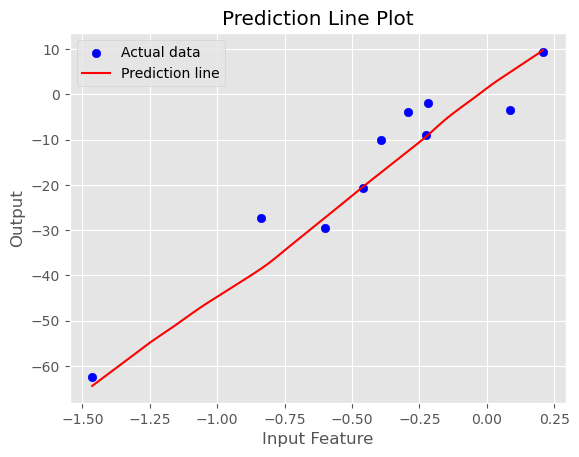

In [13]:
# Extract actual data points
actual_x = []
actual_y = []
for data, target in test_loader:
    actual_x.extend(data[:, 0].tolist())  # the first column is the feature of interest
    actual_y.extend(target.tolist())

# Generate a range of input values
x_values = np.linspace(min(actual_x), max(actual_x), 100)
x_values_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)  # Reshape for the model

# Predict using the model
model.eval()
with torch.no_grad():
    predicted_y = model(x_values_tensor).view(-1).numpy()

# Plot the actual data points
plt.scatter(actual_x, actual_y, color='blue', label='Actual data')

# Plot the decision line
plt.plot(x_values, predicted_y, color='red', label='Prediction line')

plt.xlabel('Input Feature')
plt.ylabel('Output')
plt.title('Prediction Line Plot')
plt.legend()
plt.show()
